In [1]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=0fd7680e946d56aac673c50f721570a6da914ee2da35dd3b1508cb734069862a
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-02-05 04:01:07--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-02-05 04:01:08--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>] 

In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary

In [3]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [4]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [5]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [7]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [8]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [9]:
class AttentionDownsample(nn.Module):
     def __init__(self, dim, out_dim, num_heads, attn_ratio=2):
         super(AttentionDownsample, self).__init__()
         self.num_heads = num_heads
         self.scale = (dim // num_heads) ** -0.5
         inner_dim = dim * attn_ratio * num_heads
         self.kv = LinearNorm(dim, inner_dim)

         self.q = nn.Sequential(
             nn.Conv2d(dim, dim, kernel_size=2, stride=2),
             nn.Flatten(start_dim=1)
         )

         self.proj = nn.Sequential(
             nn.Hardswish(),
             LinearNorm(dim, out_dim)
         )

     def forward(self, x):
         B, N, C = x.shape
         H = W = int(N ** 0.5)
         x = x.reshape(B, C, H, W)

         kv = self.kv(x.flatten(2).transpose(1, 2))
         q = self.q(x)

         q = q.reshape(B, -1, C)
         x = self.proj(q)
         return x

In [10]:
class LevitDownsample(nn.Module):
     def __init__(self, dim, out_dim, num_heads, attn_ratio=2):
         super(LevitDownsample, self).__init__()
         self.attn_downsample = AttentionDownsample(dim, out_dim, num_heads, attn_ratio)
         self.mlp = LevitMlp(out_dim, out_dim * attn_ratio, out_dim)
         self.drop_path = nn.Identity()
     def forward(self, x):
         x = self.attn_downsample(x)
         x = self.drop_path(self.mlp(x))
         return x

In [19]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = LevitDownsample(dim, out_dim, num_heads) if downsample else nn.Identity()  # CNN->LeViT
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [13]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [14]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [17]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=37):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [20]:
model = LevitDistilled()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
decay_rate = 1e-6
num_epochs = 30

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [21]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 37]                  --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [22]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 37]                  --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [23]:
train_dir = './train/NCT-CRC-HE-100K'

In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [25]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [26]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

data_paths, labels = zip(*dataset.samples)
labels = np.array(labels)

# 7 : 3 split
train_idx, tmp_idx, _, tmp_labels = train_test_split(
    np.arange(len(labels)), labels, test_size=0.3, stratify=labels, random_state=42
)

# 3 -> 1.5 : 1.5 split
val_idx, test_idx = train_test_split(
    tmp_idx, test_size=0.5, stratify=tmp_labels, random_state=42
)

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

In [27]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


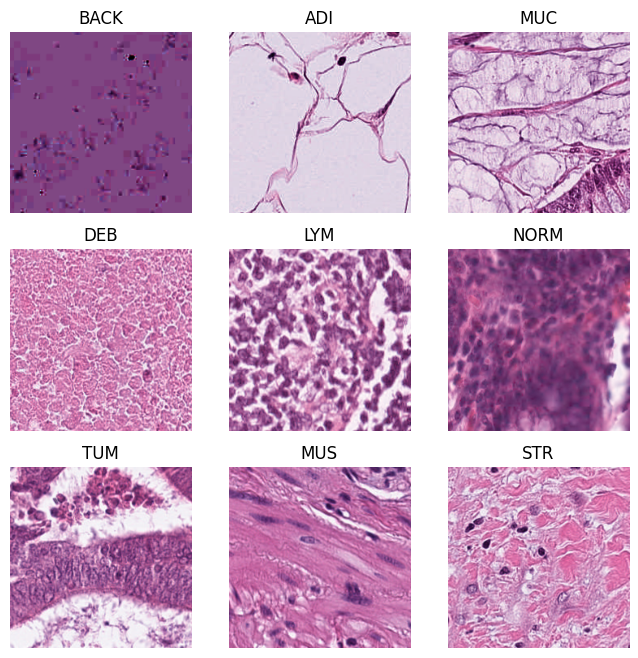

In [29]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(dataset.classes):
            break
    if len(class_examples) == len(dataset.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(dataset.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay_rate)

In [31]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [32]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [33]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [34]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [35]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [02:12<00:00, 16.47it/s]


Train Loss: 0.7052, Train Accuracy: 75.57%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]


Validation Loss: 0.3508, Validation Accuracy: 87.94%

Epoch 2/30


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.38it/s]


Train Loss: 0.3142, Train Accuracy: 89.38%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]


Validation Loss: 0.5892, Validation Accuracy: 79.72%

Epoch 3/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.85it/s]


Train Loss: 0.2194, Train Accuracy: 92.70%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]


Validation Loss: 0.5542, Validation Accuracy: 84.77%

Epoch 4/30


Training: 100%|██████████| 2188/2188 [02:10<00:00, 16.76it/s]


Train Loss: 0.1597, Train Accuracy: 94.70%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]


Validation Loss: 0.1994, Validation Accuracy: 93.11%

Epoch 5/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.95it/s]


Train Loss: 0.1214, Train Accuracy: 96.01%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]


Validation Loss: 0.2176, Validation Accuracy: 92.91%

Epoch 6/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.84it/s]


Train Loss: 0.0970, Train Accuracy: 96.80%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]


Validation Loss: 0.6713, Validation Accuracy: 80.83%

Epoch 7/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.90it/s]


Train Loss: 0.0807, Train Accuracy: 97.26%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]


Validation Loss: 1.4673, Validation Accuracy: 69.89%

Epoch 8/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.91it/s]


Train Loss: 0.0658, Train Accuracy: 97.80%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]


Validation Loss: 0.1084, Validation Accuracy: 96.49%

Epoch 9/30


Training: 100%|██████████| 2188/2188 [02:10<00:00, 16.83it/s]


Train Loss: 0.0526, Train Accuracy: 98.21%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.83it/s]


Validation Loss: 0.1499, Validation Accuracy: 95.38%

Epoch 10/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.86it/s]


Train Loss: 0.0459, Train Accuracy: 98.49%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]


Validation Loss: 0.5264, Validation Accuracy: 87.39%

Epoch 11/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.84it/s]


Train Loss: 0.0411, Train Accuracy: 98.60%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]


Validation Loss: 0.0676, Validation Accuracy: 97.87%

Epoch 12/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.84it/s]


Train Loss: 0.0356, Train Accuracy: 98.80%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.68it/s]


Validation Loss: 0.4175, Validation Accuracy: 91.09%

Epoch 13/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.86it/s]


Train Loss: 0.0316, Train Accuracy: 98.93%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]


Validation Loss: 0.1262, Validation Accuracy: 96.43%

Epoch 14/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.85it/s]


Train Loss: 0.0293, Train Accuracy: 99.03%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]


Validation Loss: 0.0862, Validation Accuracy: 97.37%

Epoch 15/30


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.44it/s]


Train Loss: 0.0280, Train Accuracy: 99.08%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]


Validation Loss: 0.8661, Validation Accuracy: 85.93%

Epoch 16/30


Training: 100%|██████████| 2188/2188 [02:10<00:00, 16.81it/s]


Train Loss: 0.0244, Train Accuracy: 99.20%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]


Validation Loss: 0.1896, Validation Accuracy: 95.06%

Epoch 17/30


Training: 100%|██████████| 2188/2188 [02:11<00:00, 16.66it/s]


Train Loss: 0.0227, Train Accuracy: 99.25%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]


Validation Loss: 0.1005, Validation Accuracy: 97.15%

Epoch 18/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.88it/s]


Train Loss: 0.0235, Train Accuracy: 99.25%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]


Validation Loss: 0.4146, Validation Accuracy: 90.13%

Epoch 19/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.90it/s]


Train Loss: 0.0197, Train Accuracy: 99.33%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]


Validation Loss: 0.0845, Validation Accuracy: 97.71%

Epoch 20/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.88it/s]


Train Loss: 0.0191, Train Accuracy: 99.38%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]


Validation Loss: 0.6655, Validation Accuracy: 87.48%

Epoch 21/30


Training: 100%|██████████| 2188/2188 [02:10<00:00, 16.81it/s]


Train Loss: 0.0186, Train Accuracy: 99.42%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.59it/s]


Validation Loss: 0.0889, Validation Accuracy: 97.63%

Epoch 22/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.87it/s]


Train Loss: 0.0179, Train Accuracy: 99.42%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]


Validation Loss: 1.5652, Validation Accuracy: 72.15%

Epoch 23/30


Training: 100%|██████████| 2188/2188 [02:10<00:00, 16.82it/s]


Train Loss: 0.0158, Train Accuracy: 99.45%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]


Validation Loss: 0.0655, Validation Accuracy: 98.19%

Epoch 24/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.90it/s]


Train Loss: 0.0157, Train Accuracy: 99.48%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]


Validation Loss: 0.1140, Validation Accuracy: 97.05%

Epoch 25/30


Training: 100%|██████████| 2188/2188 [02:10<00:00, 16.77it/s]


Train Loss: 0.0151, Train Accuracy: 99.51%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]


Validation Loss: 0.1431, Validation Accuracy: 96.18%

Epoch 26/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.84it/s]


Train Loss: 0.0149, Train Accuracy: 99.49%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]


Validation Loss: 0.0492, Validation Accuracy: 98.65%

Epoch 27/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.85it/s]


Train Loss: 0.0118, Train Accuracy: 99.62%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.50it/s]


Validation Loss: 0.0719, Validation Accuracy: 97.91%

Epoch 28/30


Training: 100%|██████████| 2188/2188 [02:10<00:00, 16.75it/s]


Train Loss: 0.0149, Train Accuracy: 99.53%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]


Validation Loss: 0.0900, Validation Accuracy: 97.77%

Epoch 29/30


Training: 100%|██████████| 2188/2188 [02:09<00:00, 16.85it/s]


Train Loss: 0.0124, Train Accuracy: 99.59%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]


Validation Loss: 0.4001, Validation Accuracy: 90.93%

Epoch 30/30


Training: 100%|██████████| 2188/2188 [02:10<00:00, 16.82it/s]


Train Loss: 0.0119, Train Accuracy: 99.63%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]

Validation Loss: 0.0641, Validation Accuracy: 98.33%


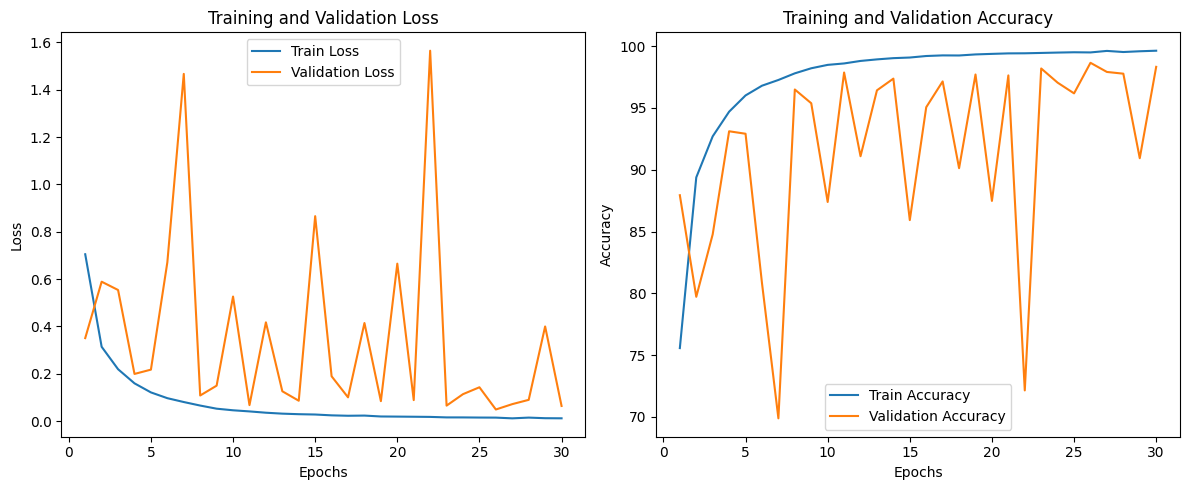

In [36]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 6.08 ms
Standard Deviation: 0.39 ms
Maximum Time: 9.02 ms
Minimum Time: 5.83 ms


In [39]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.02%     367.047us        18.06%       3.284ms     117.295us       0.000us         0.00%       3.471ms     123.975us            28  
                                           aten::linear         0.66%     119.263us        13.15%       2.392ms     108.731us       0.000us         0.00%       2.761ms     125.488us            22  
         

In [40]:
save_path = "Ablation_HoViT_attnDown.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to Ablation_HoViT_attnDown.pth


In [41]:
from sklearn.metrics import f1_score, recall_score, precision_score


def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [43]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device)

Validation: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]

Validation Loss: 0.0568, Validation Accuracy: 98.45%
Overall - F1: 0.9845, Recall: 0.9850, Precision: 0.9840
Per-Class Metrics:
Class 0 - F1: 0.9994, Recall: 0.9987, Precision: 1.0000
Class 1 - F1: 0.9972, Recall: 1.0000, Precision: 0.9944
Class 2 - F1: 0.9811, Recall: 0.9757, Precision: 0.9865
Class 3 - F1: 0.9954, Recall: 0.9983, Precision: 0.9925
Class 4 - F1: 0.9817, Recall: 0.9850, Precision: 0.9784
Class 5 - F1: 0.9874, Recall: 0.9877, Precision: 0.9872
Class 6 - F1: 0.9731, Recall: 0.9749, Precision: 0.9712
Class 7 - F1: 0.9703, Recall: 0.9796, Precision: 0.9612
Class 8 - F1: 0.9748, Recall: 0.9651, Precision: 0.9848


<Figure size 2000x1200 with 0 Axes>

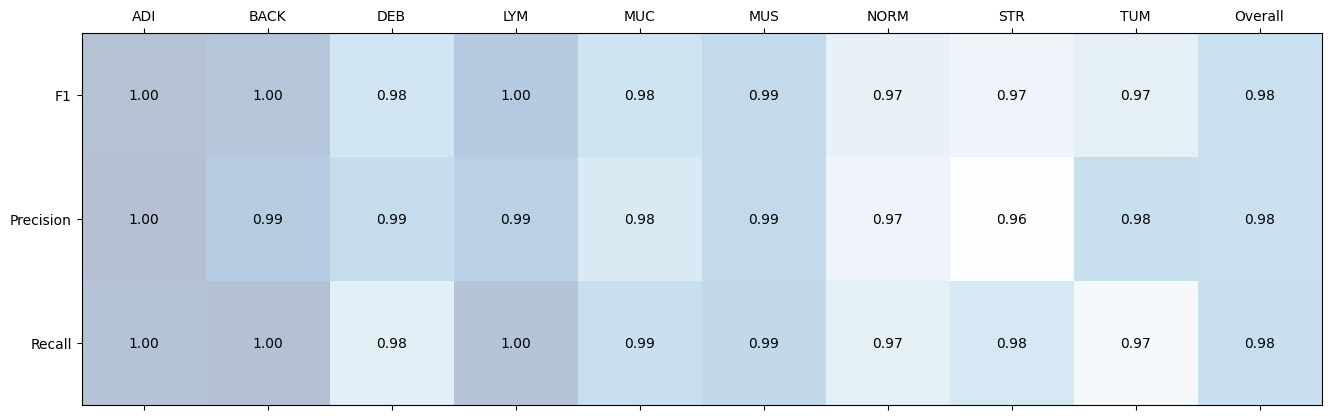

In [44]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )
